## Потоки на симплициальных комплексах и их приложения
### Flows on Simplicial Complexes and their Applications

Данный Jupyter-ноутбук является приложением к выпускной квалификационной работе студентки группы мНОД21_АИД_Б Анны Першиной

(май 2023)

Импортируем нужные библиотеки:

In [1]:
from discrete_ricci_flow import MakeDiscreteRicciFlowIterator
from enum import Enum, auto
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse.csgraph import connected_components
import seaborn as sns
from typing import NamedTuple, Optional#, TypeAlias

sns.set_style("darkgrid")

Исследуемые объекты бывают двух классов:
* `patients` (люди, у которых был продиагностирован синдром Альцгеймера)
* `controls` (люди, у которых не был выявлен синдром Альцгеймера)

In [2]:
class SubjectType(Enum):
    PATIENTS = 0
    CONTROLS = auto()

    def __str__(self) -> str:
        return self.name.lower()

Разместим данные в той же директории, что и этот jupyter notebook и сохраним в словарях `SUBJECT_TYPE_2_PATH` и `PATH_2_SUBJECT_TYPE` соответствия между путями к папкам с данными и типами исследуемых объектов в две стороны:

In [3]:
DATA_PATH = Path("//Users/annapershina/Downloads/data 2/OASIS3/ts_extracted")

def GetPathToSubjectType(subject_type: SubjectType) -> Path:
    return DATA_PATH / str(subject_type) / "AAL"

SUBJECT_TYPE_2_PATH = {
    subject_type: GetPathToSubjectType(subject_type) for subject_type in SubjectType
}

PATH_2_SUBJECT_TYPE = {
    value: key for key, value in SUBJECT_TYPE_2_PATH.items()
}

В `.csv`-файле для каждого пациента записана таблица из $117$ колонок, где каждая колонка отвечает одной из областей мозга, кроме колонки `"Unnamed: 0"`. Таким образом, мы будем рассматривать $116$ областей мозга. Для каждой области мозга в соответствующей колонке записаны численные показатели активности этой области мозга на протяжении некоторого отрезка времени. Другими словами, каждой области мозга соответствует некоторый временной ряд.

In [4]:
N_BRAIN_AREAS: int = 116

Мы получаем из этих $116$ временных рядов матрицу смежности графа из $116$ вершин, где каждая вершина также соответствует одной области мозга, следующим образом: скоррелируем эти $116$ временных рядов попарно между собой; получим матрицу корреляций размера $116 \times 116$. Поскольку коэффицент корреляции, близкий к единице, означает, что две области мозга демонстрируют похожую активность, то во взвешенном графе ребро между вершинами, соответствующие этим двум областям мозга, должно, наоборот, иметь маленький вес. Поэтому естественый способ получить по матрице корреляций матрицу смежности графа -- это заменить каждый элемент матрицы корреляций $C_{i, j}$ на $1 - C_{i, j}$.

Введём несколько вспомогатеьльных типов, в которых будем хранить данные. Будем для каждого объекта исследования хранить данные в виде пары из идентификатора объекта (из названия соотв. `.csv`-файла) и матрицы смежности графа:

In [5]:
SubjectAdjMatrix = np.ndarray[(N_BRAIN_AREAS, N_BRAIN_AREAS), np.float64]

class Subject(NamedTuple):
    type: SubjectType
    id: str
    adj_matrix: SubjectAdjMatrix

Напишем функции для построения объекта типа `Subject` (см. предыдущую ячейку) по пути к файлу с данными для заданного объекта. Матрица смежности графа строится по алгоритму, описанному выше.

In [6]:
def BuildAdjMatrixFromTablePath(subject_table_path: Path) -> SubjectAdjMatrix:
    corr_matrix = np.corrcoef(
        pd.read_csv(subject_table_path).drop('Unnamed: 0', axis=1).T
    )
    corr_matrix_abs = np.abs(corr_matrix, out=corr_matrix)
    adj_matrix = np.subtract(1, corr_matrix_abs, out=corr_matrix)
    return adj_matrix

def GetSubjectIdFromTablePath(subject_table_path: Path) -> str:
    return subject_table_path.stem

def GetSubjectTypeFromTablePath(subject_table_path: Path) -> SubjectType:
    return PATH_2_SUBJECT_TYPE[subject_table_path.parent]

def GetSubjectFromTablePath(subject_table_path: Path, subject_type: Optional[SubjectType]) -> Subject:
    return Subject(
        type=GetSubjectTypeFromTablePath(subject_table_path) if subject_type is None else subject_type,
        id=GetSubjectIdFromTablePath(subject_table_path),
        adj_matrix=BuildAdjMatrixFromTablePath(subject_table_path)
    )

In [7]:
def BuildAdjMatrixFromTablePath(subject_table_path: Path) -> SubjectAdjMatrix:
    corr_matrix = np.corrcoef(
        pd.read_csv(subject_table_path).drop('Unnamed: 0', axis=1).T
    )
    corr_matrix_abs = np.abs(corr_matrix, out=corr_matrix)
    adj_matrix = np.subtract(1, corr_matrix_abs, out=corr_matrix)
    return adj_matrix

def GetSubjectIdFromTablePath(subject_table_path: Path) -> str:
    return subject_table_path.stem

def GetSubjectTypeFromTablePath(subject_table_path: Path) -> SubjectType:
    return PATH_2_SUBJECT_TYPE[subject_table_path.parent]

def GetSubjectFromTablePath(subject_table_path: Path, subject_type: Optional[SubjectType]=None) -> Subject:
    return Subject(
        type=GetSubjectTypeFromTablePath(subject_table_path) if subject_type is None else subject_type,
        id=GetSubjectIdFromTablePath(subject_table_path),
        adj_matrix=BuildAdjMatrixFromTablePath(subject_table_path)
    )

Некоторые `.csv`-файлы, соответствующие объектам исследования, содержат некорректные данные. Эти файлы имеют размер менее `15Kb`, их мы отфильтруем при чтении.

In [8]:
MIN_SIZE_BYTES: int = 15 * 1024 # ораничение снизу на размер корректного файла

Напишем функцию, которая прочитает с диска данные обо всех объектах и сложит их в список объектов типа `Subject` для заданного класса объектов:

In [9]:
def ReadAllSubjectsData(subject_type: SubjectType) -> list[Subject]:
    subjects_path = SUBJECT_TYPE_2_PATH[subject_type]

    data = [
        GetSubjectFromTablePath(subject_table_path, subject_type)
        for subject_table_path in subjects_path.iterdir() if subject_table_path.stat().st_size > MIN_SIZE_BYTES
    ]

    return data

С помощью этой функции прочитаем все данные:

In [10]:
patients = ReadAllSubjectsData(SubjectType.PATIENTS)
controls = ReadAllSubjectsData(SubjectType.CONTROLS)

Посмотрим на гистограмму весов рёбер графа для первого пациента (здесь каждое ребро будет учтено дважды, так как матрица смежности симметрична относительно диагонали; но для представления о том, как распределены веса рёбер, это не играет большой роли).

Предварительно сконструируем маску, которая соответствует выбору всех не-диагональных элементов матрицы. Это нужно, чтобы в гистограмме не учитывать нулевые рёбра на диагонали матрицы.

In [11]:
NON_DIAGONAL_MASK = ~np.diag(np.ones(N_BRAIN_AREAS, dtype=np.bool8))

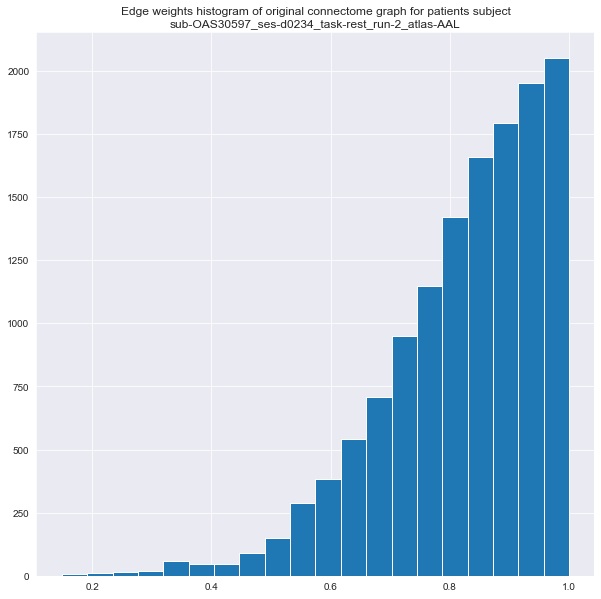

In [12]:
subject = patients[0]

fig = plt.figure(figsize=(10, 10))
plt.hist(subject.adj_matrix[NON_DIAGONAL_MASK], bins=20)
plt.title(f"Edge weights histogram of original connectome graph for {subject.type} subject\n{subject.id}")

plt.show()

Запустим 200 итераций дискретного потока Риччи на данном графе и проследим за тем, как будет меняться гистограмма весов рёбер.

Для начала скопируем матрицу смежности рассматриваемого объекта, чтобы менять in-place эту копию (реализованный итератор дискретного потока Риччи эффективнее работает в режиме, когда он может менять переданную матрицу смежности in-place под действием потока):

In [13]:
subject_adj_matrix = np.copy(subject.adj_matrix)

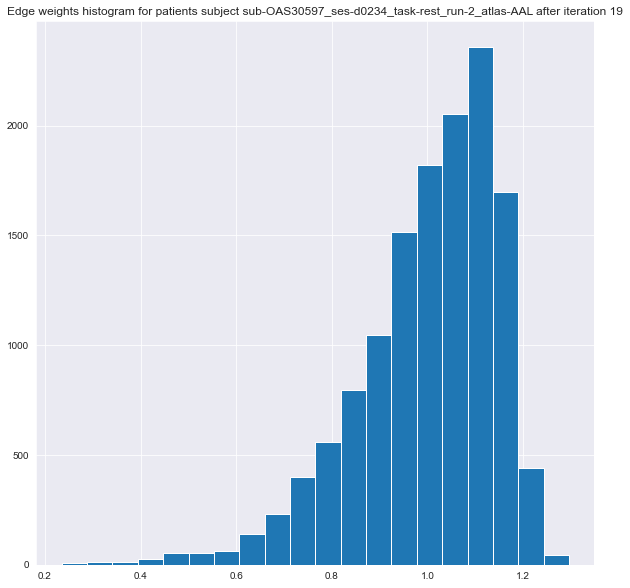

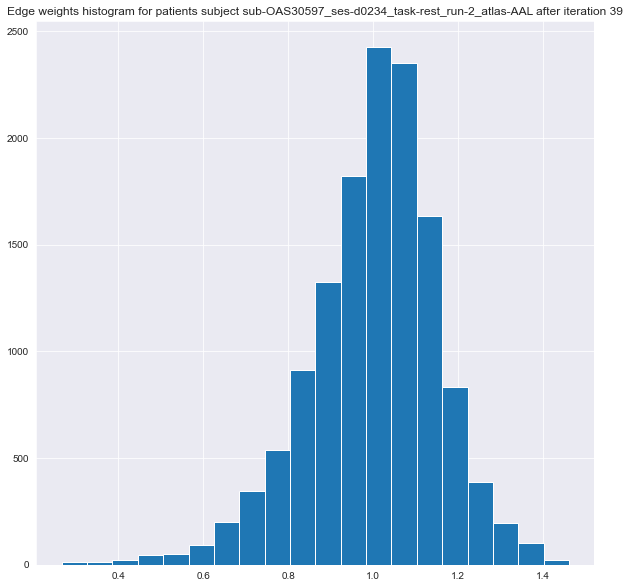

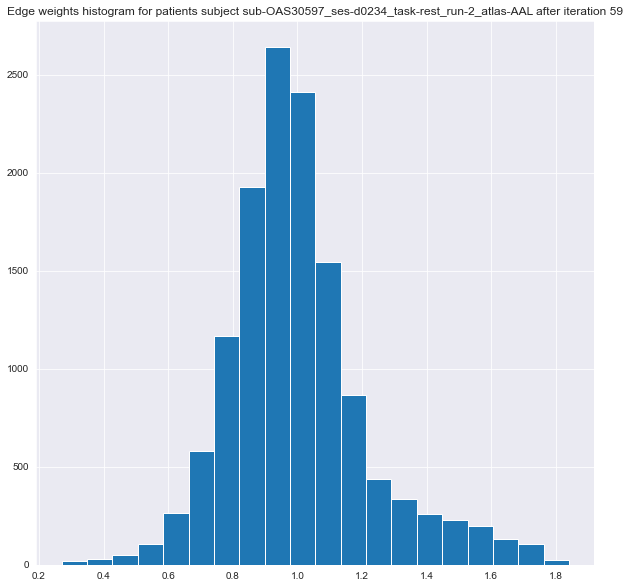

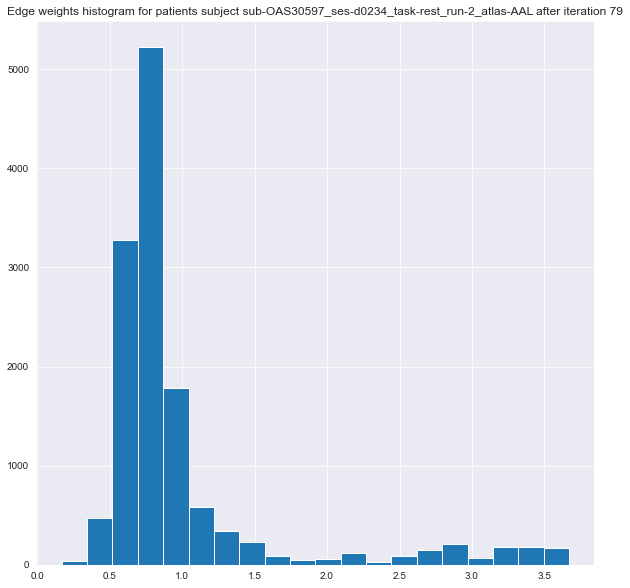

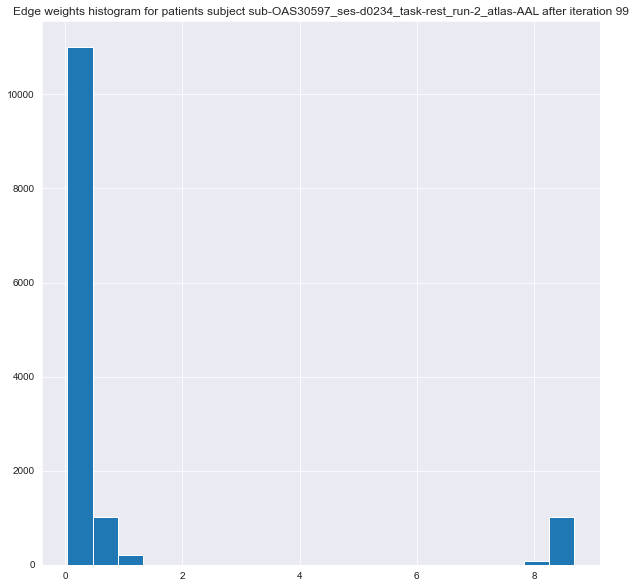

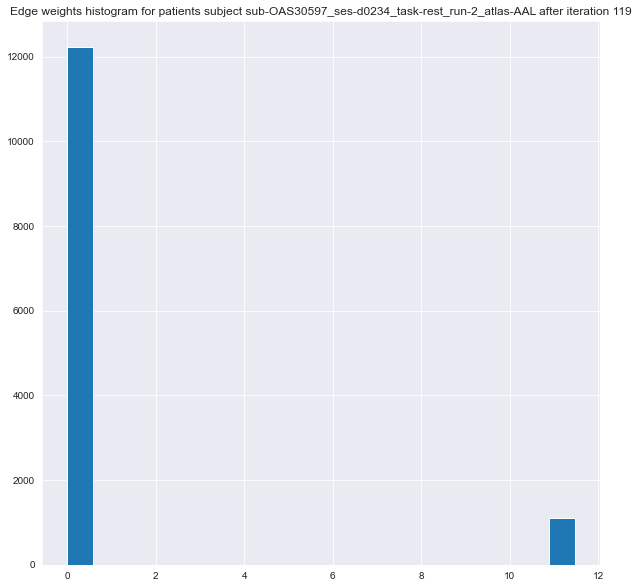

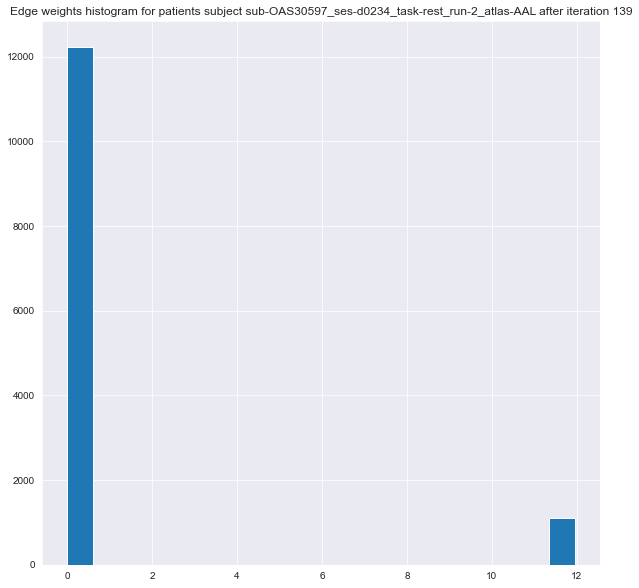

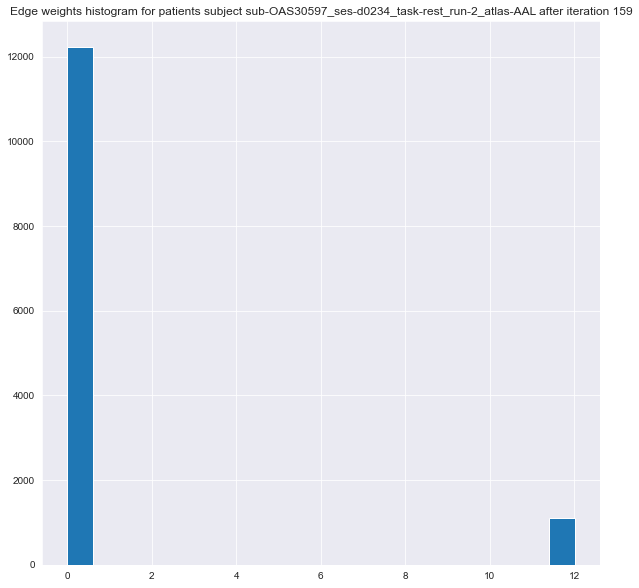

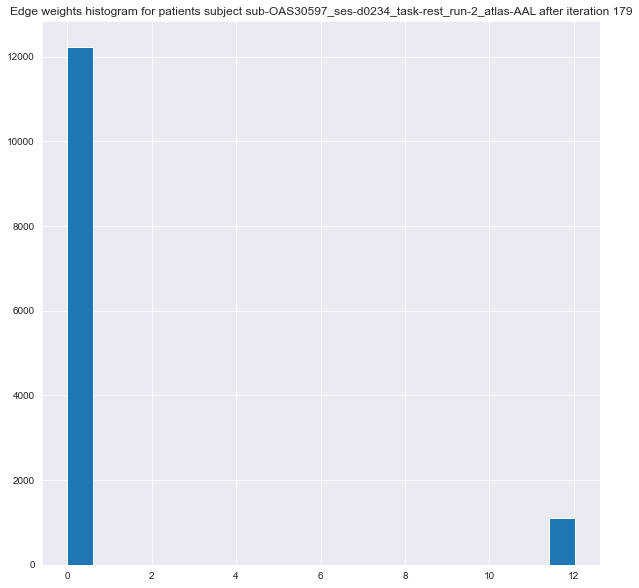

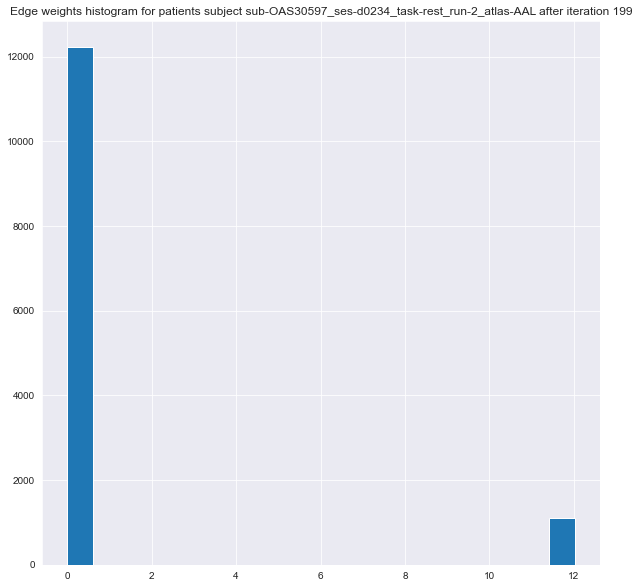

CPU times: user 24min 32s, sys: 8.1 s, total: 24min 40s
Wall time: 24min 39s


In [14]:
%%time

make_discrete_ricci_flow_iteration = MakeDiscreteRicciFlowIterator(
    N=N_BRAIN_AREAS,
    alpha=0.5,
    exp_power=2,
    eps=0.2
)

subject_adj_matrix_stages = []


for i in range(200):
    make_discrete_ricci_flow_iteration(subject_adj_matrix)
    subject_adj_matrix_stages.append(np.copy(subject_adj_matrix))

    if i % 20 == 19:
        fig = plt.figure(figsize=(10, 10))
        plt.hist(subject_adj_matrix[NON_DIAGONAL_MASK], bins=20)
        plt.title(f"Edge weights histogram for {subject.type} subject {subject.id} after iteration {i}")
        plt.show()

На последних гистограммах видно, что веса рёбер разделились на большие и близкие к нулю.

Проведём т.н. "хирургию" для дискретного потока Риччи. Эта операция состоит в том, что из графа удаляются рёбра большого веса, в результате чего граф разбивается на подграфы, которые можно считать за найденные "сообщества" в исходном графе.

В нашем случае провести хирургию очень просто, так как все рёбра явно разделились на тяжёлые и нулевые. Достаточно отсортировать рёбра по весу и в отсортированном массиве рёбер найти такой индекс $i$, что разность между $(i + 1)$-м и $i$-м элементом будет максимальной. После чего можно удалить все рёбра от $0$-го до $i$-го включительно. Проделаем эту процедуру.

Находим максимальную разность между соседними весами:

In [15]:
all_edge_weights_sorted = np.sort(subject_adj_matrix.reshape(-1))
max_diff_idx = np.argmax(all_edge_weights_sorted[1:] - all_edge_weights_sorted[:-1])

print(
    "Max diff is between consequtive weights {} and {}".format(
        all_edge_weights_sorted[max_diff_idx],
        all_edge_weights_sorted[max_diff_idx + 1]
    )
)

print("Max diff idx:", max_diff_idx)

Max diff is between consequtive weights 4.523080047429452e-05 and 12.01785885718755
Max diff idx: 12345


Удаляем все рёбра, вес которых меньше найденной границы. Веса оставшихся рёбер для простоты делаем равными 1.

In [16]:
subject_adj_matrix_after_edge_cut = subject_adj_matrix < all_edge_weights_sorted[max_diff_idx + 1]

Смотрим на компоненты связности полученного графа:

In [17]:
n_components, labels = connected_components(subject_adj_matrix_after_edge_cut, directed=False)

print("Number of components: ", n_components, end="\n\n")
for i in range(n_components):
    print(f"Component {i}:\n", *np.where(labels == i), end="\n\n")

Number of components:  2

Component 0:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  44  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115]

Component 1:
 [42 43 45 46 47]



## Машинное обучение

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data_path = Path("//Users/annapershina/Documents/processed_connectomes")

In [ ]:
controls_path = data_path / "controls_results/adj_matrices"
patients_path = data_path / "patients_results/adj_matrices"

In [ ]:
X = []
y = []
for item in controls_connectomes:
    X.append(item.flatten())
    y.append(False)
for item in patients_connectomes:
    X.append(item.flatten())
    y.append(True)
X = np.array(X)
y = np.array(y)

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
sum(y_pred == y_test) / len(y_pred == y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, LeaveOneOut

In [ ]:
n_neighbors_variants = [1, 3, 5, 7, 9, 11, 15, 21, 29]

In [ ]:
%%time
for n_neighbors in n_neighbors_variants:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    score = 0
    # precision_score_u, precision_score_l = 0, 0
    # recall_score_u, recall_score_l = 0, 0
    tp, fp, tn, fn = 0, 0, 0, 0
    final_test = []
    final_pred = []
    for train_index, test_index in LeaveOneOut().split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score += (clf.predict(X_test)[0] == y_test[0])
        #print(clf.predict(X_test), y_test, ((clf.predict(X_test)[0] == True) and (y_test[0] == True)))
        # precision_score_u += ((clf.predict(X_test)[0] == True) and (y_test[0] == True))
        # precision_score_l += (clf.predict(X_test)[0] == True)
        # recall_score_u += ((clf.predict(X_test)[0] == True) and (y_test[0] == True))
        # recall_score_l += (y_test[0] == True)
        tp += ((clf.predict(X_test)[0] == True) and (y_test[0] == True))
        fp += ((clf.predict(X_test)[0] == True) and (y_test[0] != True))
        tn += ((clf.predict(X_test)[0] != True) and (y_test[0] != True))
        fn += ((clf.predict(X_test)[0] != True) and (y_test[0] == True))
        final_test.append(y_test[0])
        final_pred.append(clf.predict(X_test)[0])
    # print("KNN leave-one-out accuracy for {} neighbors on processed with Ricci flow:".format(n_neighbors), np.round(score / len(X), 3))
    # print("TP: ", tp, "FP: ", fp, "TN: ", tn, "FN: ", fn)
    # print("Precision: ", tp / (tp + fp), " Recall: ", tp / (tp + fn))
    print(n_neighbors)
    print(np.round(score / len(X), 3), np.round(tp / ( tp + fp), 3), np.round(tp / (tp + fn), 3))

In [ ]:
for i, j in zip(final_pred, final_test):
    print(i,j)